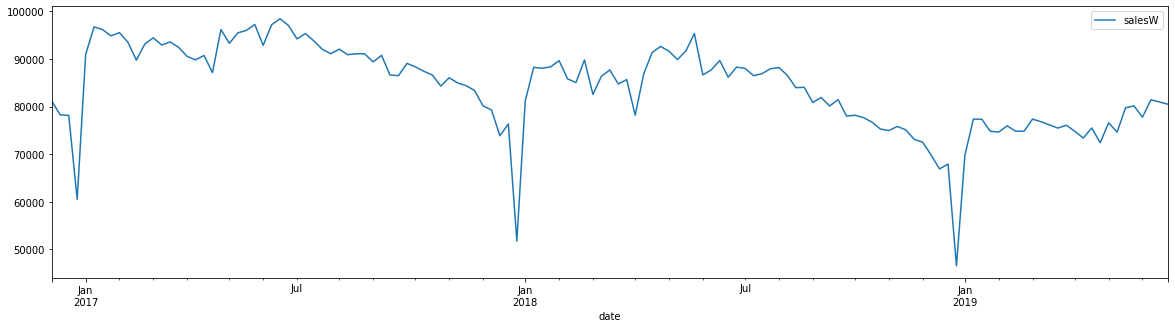

In [1]:
import pandas as pd
import numpy as np
import math
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

pd.set_option('display.max_columns', 5400)
pd.set_option('display.max_colwidth', 500)
frame= pd.read_csv('train.csv')

frame.rename(columns={
    'Unnamed: 0':'date',
    'size (GM)':'size',
    'POS_exposed w-1':'NumStoreEvidW-1',
    'volume_on_promo w-1':'percProdPromoW-1',
    'sales w-1':'salesW-1',
    'target':'salesW'},inplace=True)


def cutWE(x):
    return x[2:]

frame['date']=frame['date'].apply(cutWE)
frame['date']=pd.to_datetime(frame['date']) 
frame.set_index('date',inplace=True)
#------------------------------------basta mettere uno sku qualsisi al posto di 1608 per fare ADF test delle sales
pf=frame[frame['sku']==2705]#1608 una super ripetitiva 1027 una poco ripetitiva #2705 è abba ripetitirva
pf.plot(y='salesW',kind='line',figsize=(20,5))

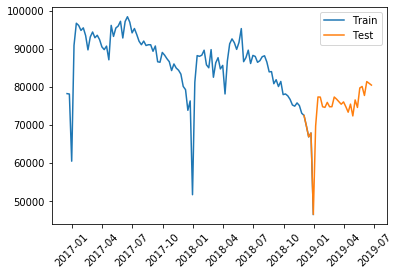

RMSE on Test 6002.016
mape nostro: 0.055250276443212995
MAPE on Test 5.525
E' IL MAPE MINIMO, QUELLO DOVE OREDICO VENDITE IN BASE AL GIORNO PRIMA ! ORA DEVO FARE MODELLI CON TANTI GIORNI PRIMA come predittori


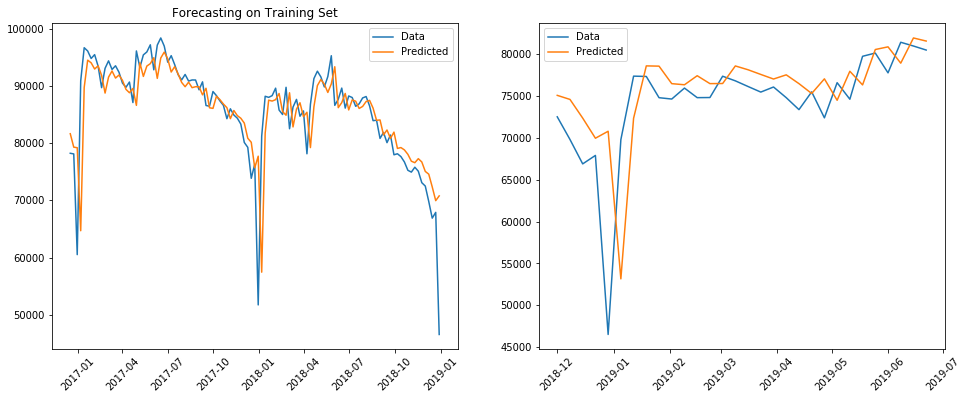

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso,Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# create a data frame from a stock series
df_stock = pd.DataFrame()
df_stock['t'] = pf['salesW']

# add the t-1 lag
df_stock['t-01'] = df_stock['t'].shift()
#print(df_stock['salesW'])
# eliminate the trailing NaN
df_stock.dropna(inplace=True)

target_variable = 't'
input_variables = df_stock.columns[df_stock.columns!=target_variable]


X=df_stock[input_variables]
y=df_stock[target_variable]

X_train, X_test = X[:'2018-12'], X['2018-12':]
y_train, y_test = y[:'2018-12'], y['2018-12':]

plt.plot(y_train,label='Train')
plt.plot(y_test,label='Test')
plt.xticks(rotation=45)
plt.legend()
plt.show()

lr_model = LinearRegression()
lr_model.fit(X_train,y_train)

yt = lr_model.predict(X_train)
yp = lr_model.predict(X_test)

print('RMSE on Test %.3f'%math.sqrt(mean_squared_error(yp,y_test)))

df_result_train = pd.DataFrame(y_train)
df_result_train['predicted'] = yt
df_result_test = pd.DataFrame(y_test)
df_result_test['predicted'] = yp

fig,axes = plt.subplots(1,2,figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(df_result_train['t'],label='Data')
plt.plot(df_result_train['predicted'],label='Predicted')

plt.xticks(rotation=45)
plt.title("Forecasting on Training Set")
plt.legend();

plt.subplot(1,2,2)
plt.plot(df_result_test['t'],label='Data')
plt.plot(df_result_test['predicted'],label='Predicted')

plt.xticks(rotation=45)
#plt.title("Forecasting on Test Set MAPE= "+str(mape(y_test,yp)))
plt.legend();

print("mape nostro: "+str(  np.mean(np.abs(((y_test-yp)/y_test))))  )

def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('MAPE on Test %.3f'%mape(y_test,yp))


print("E' IL MAPE MINIMO, QUELLO DOVE OREDICO VENDITE IN BASE AL GIORNO PRIMA ! ORA DEVO FARE MODELLI CON TANTI GIORNI PRIMA come predittori")

C:\Users\aless\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 398824731.1991137, tolerance: 706616.1662903226
  positive)


RMSE on Test 6318.408
MAPE on Test 6.143


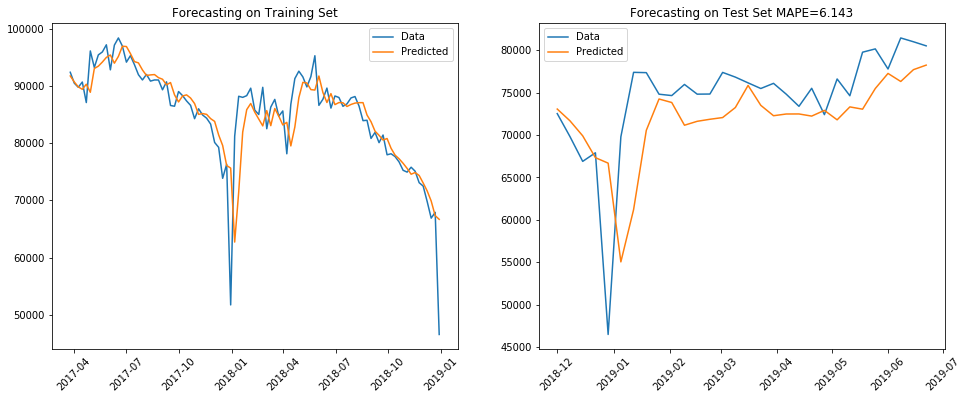

In [3]:
#--------agg variabili
def add_variables(df, target_variable, lags=0, diffs=[], rolling_windows=[]):
    df_forecasting = pd.DataFrame(df[target_variable])
    
    # add the lags
    if (lags>0):
        for i in range(1,lags+1):
            df_forecasting[target_variable+'-%02d'%i] = df_forecasting[target_variable].shift(i)

    if ((target_variable+'-01') in df_forecasting.columns):
        for diff in diffs:
            df_forecasting[target_variable+'-diff%d'%diff] = df_forecasting[target_variable+'-01'].diff(diff)
                
        for window in rolling_windows:
            df_forecasting["t-01-rw"+str(window)] = df_forecasting["t-01"].rolling(window = window).mean()

    df_forecasting.dropna(inplace=True)
    
    return df_forecasting

# create a data frame from a stock series
df_stock = pd.DataFrame()
df_stock['t'] = pf['salesW']

df_stock = add_variables(df_stock,'t',lags=5,diffs=[1,5,10],rolling_windows=[5,10,15])#qui puoi giocarci abbastanza
target_variable = 't'
input_variables = df_stock.columns[df_stock.columns!=target_variable]

X=df_stock[input_variables]#ha dentro un sacco di roba i diff le finestre temporali vecchie ecc
#in X puoi mettere eventualmente promo e tutte quelle menate per dare piu precisione o beni complementari e così via
#Occhio alle festività!  A Natale  e Pasqua!
y=df_stock[target_variable]

X_train, X_test = X[:'2018-12'], X['2018-12':]
y_train, y_test = y[:'2018-12'], y['2018-12':]

lr_model = Lasso()#Lasso,Ridge,Linar
lr_model.fit(X_train,y_train)

yt = lr_model.predict(X_train)
yp = lr_model.predict(X_test)

print('RMSE on Test %.3f'%math.sqrt(mean_squared_error(yp,y_test)))
print('MAPE on Test %.3f'%mape(y_test,yp))

df_result_train = pd.DataFrame(y_train)
df_result_train['predicted'] = yt
df_result_test = pd.DataFrame(y_test)
df_result_test['predicted'] = yp

fig,axes = plt.subplots(1,2,figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(df_result_train['t'],label='Data')
plt.plot(df_result_train['predicted'],label='Predicted')

plt.xticks(rotation=45)
plt.title("Forecasting on Training Set")
plt.legend();

plt.subplot(1,2,2)
plt.plot(df_result_test['t'],label='Data')
plt.plot(df_result_test['predicted'],label='Predicted')

plt.xticks(rotation=45)
plt.title("Forecasting on Test Set MAPE=%.3f"%mape(y_test,yp))
plt.legend();


OCCHIO A QUELLI IN NEGATIVO CHE DANNO FASTIODO!!!


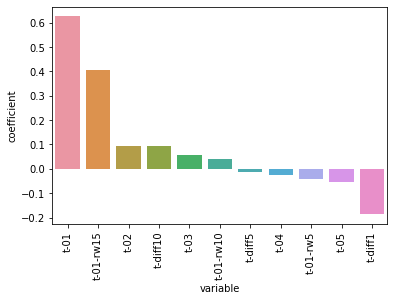

In [4]:
print("OCCHIO A QUELLI IN NEGATIVO CHE DANNO FASTIODO!!!")
lasso_coefficients = pd.DataFrame({'variable':X.columns, 'coefficient':lr_model.coef_}).sort_values(by=['coefficient'],ascending=False)
sns.barplot(x='variable',y='coefficient',data=lasso_coefficients);
plt.xticks(rotation=90);

forest prediction
RMSE on Test 8580.736
MAPE on Test 8.785


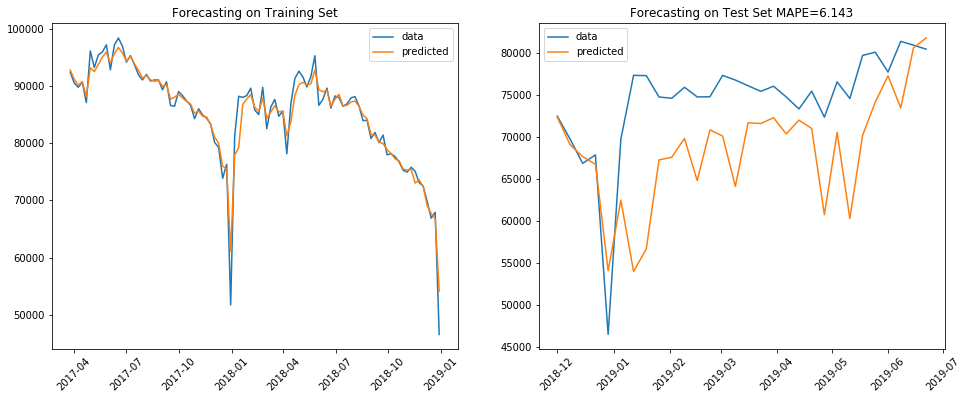

In [5]:

print("forest prediction")
forest = RandomForestRegressor(n_estimators=500, random_state=1)
forest.fit(X_train, y_train)

forest_yt = forest.predict(X_train)
forest_yp = forest.predict(X_test)

print('RMSE on Test %.3f'%math.sqrt(mean_squared_error(y_test,forest_yp)))
print('MAPE on Test %.3f'%mape(y_test,forest_yp))

df_result_forest_train = pd.DataFrame(y_train)
df_result_forest_train['predicted'] = forest_yt
df_result_forest_test = pd.DataFrame(y_test)
df_result_forest_test['predicted'] = forest_yp

fig,axes = plt.subplots(1,2,figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(df_result_forest_train['t'],label='data')
plt.plot(df_result_forest_train['predicted'],label='predicted')

plt.xticks(rotation=45)
plt.title("Forecasting on Training Set")
plt.legend();

plt.subplot(1,2,2)
plt.plot(df_result_forest_test['t'],label='data')
plt.plot(df_result_forest_test['predicted'],label='predicted')

plt.xticks(rotation=45)
plt.title("Forecasting on Test Set MAPE=%.3f"%mape(y_test,yp))
plt.legend();

In [63]:
listone=list(dict.fromkeys(frame['sku']))#listone contiene i singoli sku
#linear regression su tutto però escludo il test set e mi creo mio validation

def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mapeTot,elem=0,0

for i in listone:
    pf=frame[frame['sku']==i]
    if (pf.iloc[0]['scope']==1) | (pf.iloc[0]['sku']==1608):#scarto test set
        continue
        
    df_stock = pd.DataFrame()
    df_stock['t'] = pf['salesW']

    # add the t-1 lag
    #df_stock['t-01'] = df_stock['t'].shift()
    #df_stock['t-03'] = df_stock['t'].shift(2)
    #df_stock['t-03'] = df_stock['t'].shift(3)
    
    #print(df_stock['salesW'])
    
    
    #--------------DOVE DO' LA DROGA AI DATI
    
    #1) aggiunge diff e lag di tempo
    df_stock = add_variables(df_stock,'t',lags=2,diffs=[1],rolling_windows=[1,5])#qui puoi giocarci abbastanza
    #df_stock['price']=pf['price']
    #priceCorr,_=pearsonr(pf['salesW'],pf['price'])
    
    
    
        
    from scipy.stats import pearsonr
    
    #2)se corrente sku ha correlazioni con altri sku aggiungo le loro vendite 
    for j in listone:
        if (j==i) | (frame.iloc[0]['sku']==i):
            continue
        curr=frame[frame['sku']==j]
        
        pearsonCorrSales,_=pearsonr(pf['salesW'],curr['salesW'])
        #qui posso piazzarci altre corr da controllare con altri prodotti
        
        if pearsonCorrSales>0.6 :#se ho alta correlazione(o contraria) ci metto altri prodotti complementari
            df_stock['prod'+str(frame.iloc[0]['sku'])]=curr['salesW']
            df_stock['prod'+str(frame.iloc[0]['sku'])+'W-1']=curr['salesW-1']
            df_stock['prod'+str(frame.iloc[0]['sku'])+'W-2']=curr['salesW'].shift(2)
            
    #-------------------------------------------
    # eliminate the trailing NaN
    df_stock.dropna(inplace=True)
    
    target_variable = 't'
    input_variables = df_stock.columns[df_stock.columns!=target_variable]


    X=df_stock[input_variables]
    y=df_stock[target_variable]

    X_train, X_test = X[:'2018-12'], X['2018-12':]
    y_train, y_test = y[:'2018-12'], y['2018-12':]

    #plt.plot(y_train,label='Train')
    #plt.plot(y_test,label='Test')
    #plt.xticks(rotation=45)
    #plt.legend()
    #plt.show()

    lr_model = LinearRegression()
    lr_model.fit(X_train,y_train)

    yt = lr_model.predict(X_train)
    yp = lr_model.predict(X_test)

    print('RMSE on Test %.3f'%math.sqrt(mean_squared_error(yp,y_test)))

    #df_result_train = pd.DataFrame(y_train)
    #df_result_train['predicted'] = yt
    #df_result_test = pd.DataFrame(y_test)
    #df_result_test['predicted'] = yp

    #fig,axes = plt.subplots(1,2,figsize=(16,6))
    #plt.subplot(1,2,1)
    #plt.plot(df_result_train['t'],label='Data')
    #plt.plot(df_result_train['predicted'],label='Predicted')

    #plt.xticks(rotation=45)
    #plt.title("Forecasting on Training Set")
    #plt.legend();

    #plt.subplot(1,2,2)
    #plt.plot(df_result_test['t'],label='Data')
    #plt.plot(df_result_test['predicted'],label='Predicted')

    #plt.xticks(rotation=45)
    #plt.title("Forecasting on Test Set MAPE= "+str(mape(y_test,yp)))
    #plt.legend();

    print("mape del prod con sku: "+str(pf.iloc[0]['sku'])+" : "+str(  np.mean(np.abs(((y_test-yp)/y_test))))  )
    mapeTot=mapeTot+mape(y_test,yp)
    elem=elem+1


print('MAPE totale %.3f'%(mapeTot/elem))


#print("E' IL MAPE MINIMO, QUELLO DOVE OREDICO VENDITE IN BASE AL GIORNO PRIMA ! ORA DEVO FARE MODELLI CON TANTI GIORNI PRIMA come predittori")

RMSE on Test 2849.658
mape del prod con sku: 2689 : 0.16047809596793014
RMSE on Test 893.669
mape del prod con sku: 2696 : 0.04759490681877756
RMSE on Test 1610.835
mape del prod con sku: 2698 : 0.1445309202585145
RMSE on Test 1653.141
mape del prod con sku: 2704 : 0.06670271285319705
RMSE on Test 1436.095
mape del prod con sku: 1554 : 0.027185697137538375
RMSE on Test 3621.543
mape del prod con sku: 2705 : 0.03482759641116378
RMSE on Test 2463.721
mape del prod con sku: 2707 : 0.04758097218103784
RMSE on Test 1949.751
mape del prod con sku: 2711 : 0.15780228443258054
RMSE on Test 1190.228
mape del prod con sku: 2712 : 0.04187572341924179
RMSE on Test 1518.445
mape del prod con sku: 2718 : 0.034582749026728414
RMSE on Test 2245.470
mape del prod con sku: 2360 : 0.1715999402152019
RMSE on Test 788.369
mape del prod con sku: 2365 : 0.09690688736062923
RMSE on Test 1901.920
mape del prod con sku: 1472 : 0.043721964297822914
RMSE on Test 4207.747
mape del prod con sku: 1600 : 0.05353050788